### Model evaluation

We evaluat ehte three models using different 

1. Pseudo FID: We compute the Frecht distance between the CLIP () embdeddings of the dataset and .... generated images.
2. LPIP sdisnrtace

We first load the necessary code.

In [75]:
import torchvision
import torch
import json
import os
import sys
import numpy as np 
import lightning as L
import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

from lightning.pytorch.utilities.model_summary import ModelSummary
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.transforms import v2

plt.rcParams["savefig.bbox"] = 'tight'

# Adding the package in loading path
sys.path.extend(["../"])

import gencellpainting as gc
from gencellpainting.utils.dataset import WGANCriticDataset, CellPaintingDatasetInMemory
from gencellpainting.model import *

In [ ]:
PATH_ROOT = os.path.abspath("../..")

# Path of the data to update if you want to run this script
PATH_DATASET = os.path.join(PATH_ROOT,"data","jump_64px_uint8.pt")
# Path of saved models
PATH_OUTPUT= os.path.join(PATH_ROOT,"output")
PATH_MODEL = os.path.join(PATH_OUTPUT,"models")


In [3]:
NREPEAT = 3

We first load the  full dataset, which will be used to compute the distribution of CLIP embeddings

In [4]:
ds = CellPaintingDatasetInMemory(tensor=torch.load(PATH_DATASET))

Defining the correct transformation, ensuring that image are between 0 and 1

In [5]:
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True) # Tensor values [0, 255] -> [0.0, 1.0]
])
# We pass it directly to the datasets transfroms for convenience.
ds.transform = transforms

We create the subset of the data and the data loader

In [6]:
ds = torch.utils.data.Subset(ds,range(2500))
dl = torch.utils.data.DataLoader(ds, batch_size=64, drop_last=True)

Given that the diffusion model epect input between [-1,1] we need to provide him with a specific dataloader

In [7]:
def collate_diff_batch(batch):
    gen_imgs = batch
    gen_imgs = torch.stack(gen_imgs)
    gen_imgs = gen_imgs * 2. - 1.
    return gen_imgs
dl_diff = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=True, collate_fn=collate_diff_batch, num_workers=4)

We load the pretrained models

In [29]:
wgangp = WGAN_GP.load_from_checkpoint(os.path.join(PATH_MODEL,"WGANGP")).to("cuda")
diffusion = DiffusionProcess.load_from_checkpoint(os.path.join(PATH_MODEL,"DIFFUNET")).to("cuda")
vae = VAE.load_from_checkpoint(os.path.join(PATH_MODEL,"VAE")).to("cuda")
MODELS = {
    "VAE": (vae,dl),
    "WGANGP": (wgangp,dl),
    "Diff-UNet": (diffusion,dl_diff)
}

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [82]:
ModelSummary(MODELS["Diff-UNet"][0])

  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | loss       | SmoothL1Loss    | 0      | train
1 | model      | UNetDiffusionV2 | 1.9 M  | train
2 | time_model | Sequential      | 6.0 K  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.664     Total estimated model params size (MB)
230       Modules in train mode
0         Modules in eval mode

We sample a batch for the auto-encoder.

In [30]:
NIMGS = 4
GENERATED_IMAGES = {}
for key,(model,vdl) in MODELS.items():
    batch = next(iter(vdl)).to("cuda")
    batch = batch[:NIMGS, :, :, :]
    gen_imgs = model.generate_images(n=NIMGS, batch=batch)
    GENERATED_IMAGES[key] = gen_imgs

We can redefine some plotting functions

In [31]:
# Visualization function taken from  https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    return fig

def plot_cellpainting_image(image, nrow=3):
    imgs = list(torch.split(image,1,dim=0))
    grid = torchvision.utils.make_grid(imgs,nrow = nrow)
    return show(grid)


We cna use it to plot some generated images

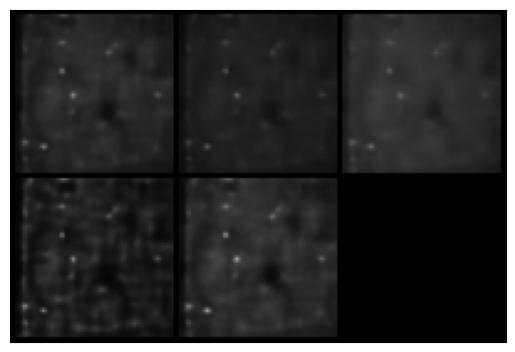

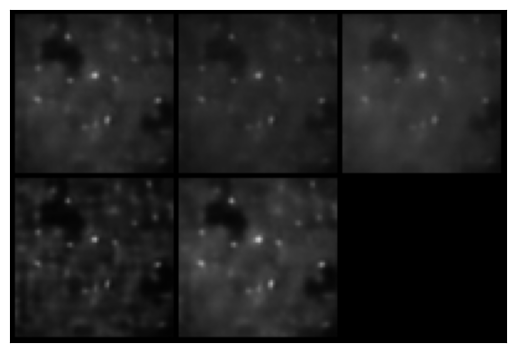

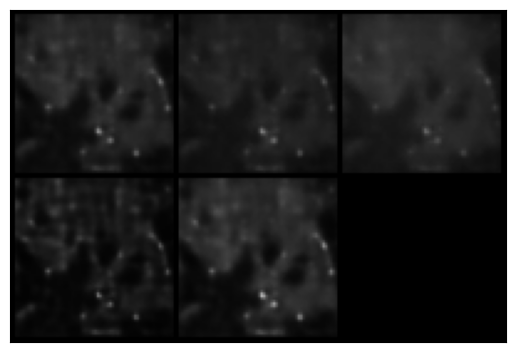

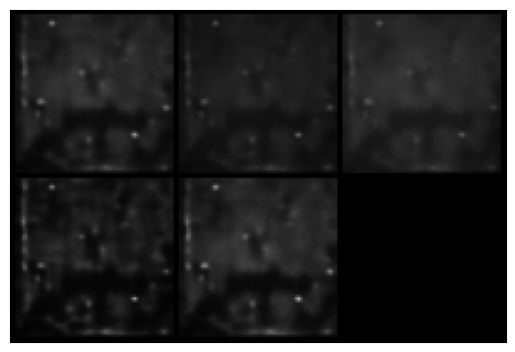

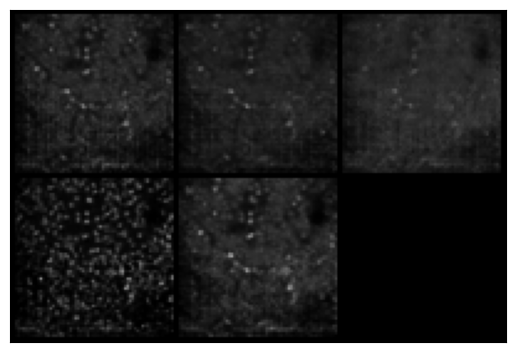

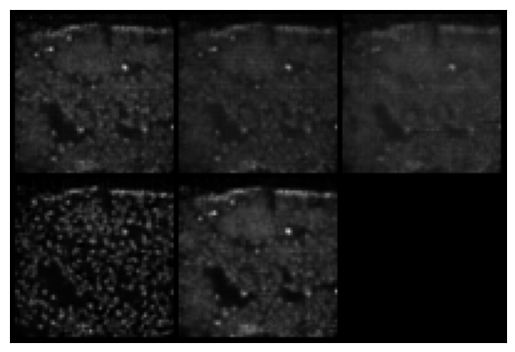

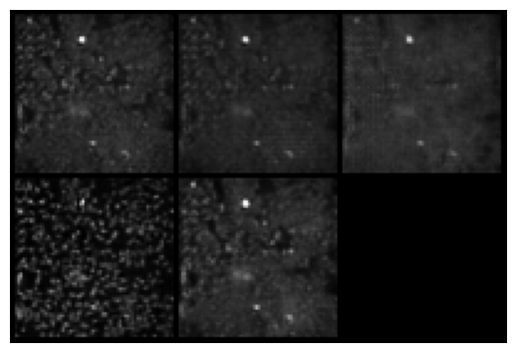

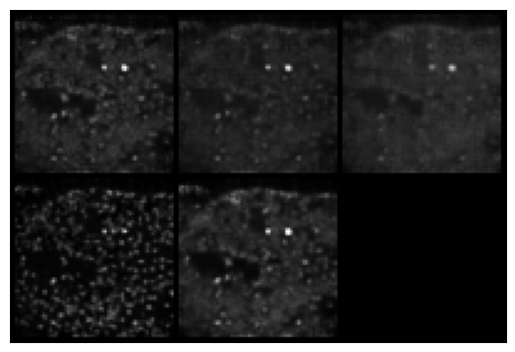

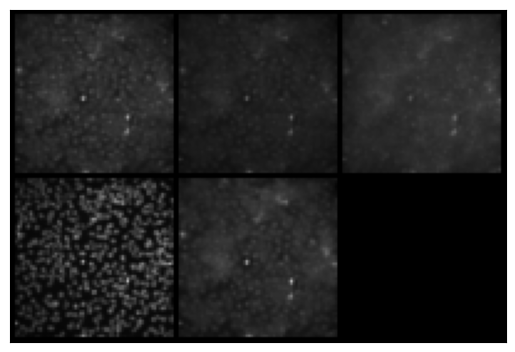

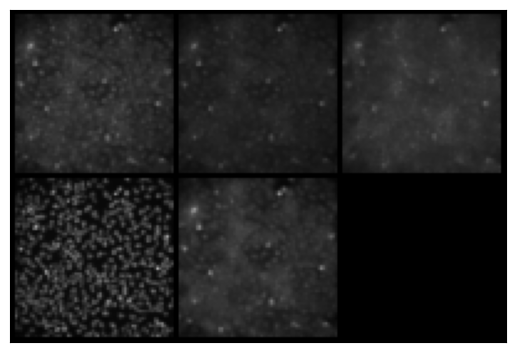

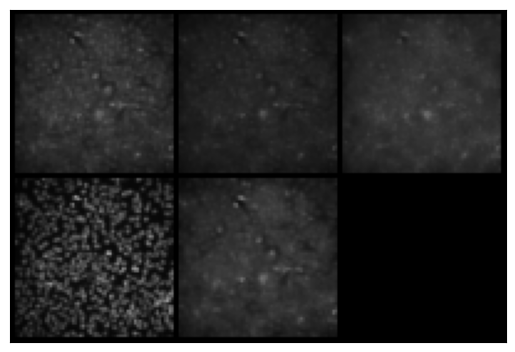

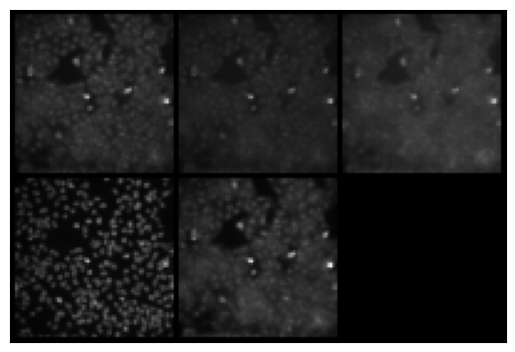

In [32]:
for key,gens in GENERATED_IMAGES.items():
    for i in range(gens.shape[0]):
        gen_img = gens[i]
        # Rescaling for diffuison model
        if gen_img.min()<0:
            gen_img = (gen_img+1.)/2.
        fig = plot_cellpainting_image(gen_img)
        fig.savefig("../../data/images/gen_{}_{}.png".format(key,i))

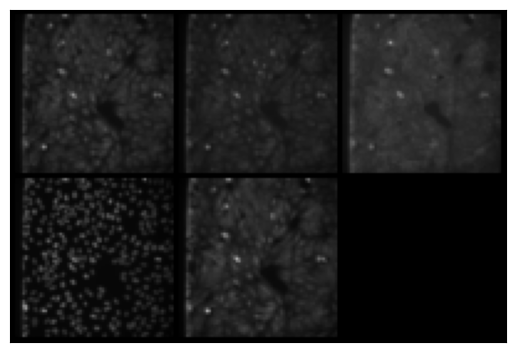

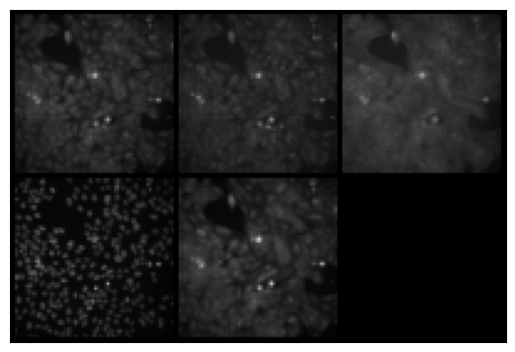

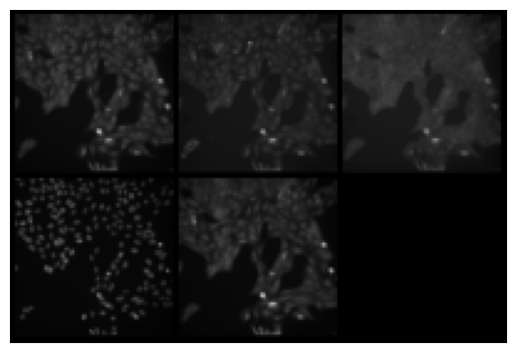

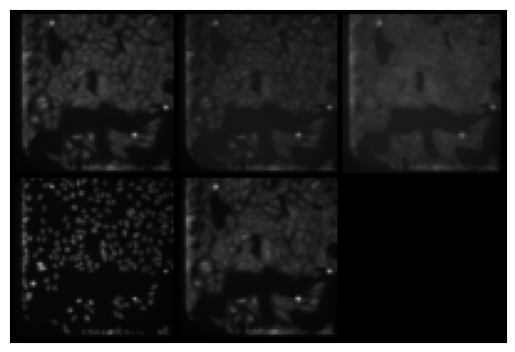

In [33]:
for i in range(NIMGS):
    fig = plot_cellpainting_image(ds[i])
    fig.savefig("../../data/images/real_{}.png".format(i))

We also plot the real images for comparisons

In [36]:
fid = FrechetInceptionDistance(feature=768)

In [37]:
class InceptionFIDWrapper(torch.nn.Module):
    def __init__(self, inception):
        super().__init__()
        self.inception = inception
        self.upsample_layer = torch.nn.Upsample(size=(299,299),mode="bilinear")

    @torch.inference_mode()
    def prepare_tensors(self,tens):
        # Consider each of the cellpainting channel as 1 separate image then replicate the channel to convert to RGB expected by CLIP.
        B,C,H,W = tens.shape
        tens =  tens.repeat_interleave(3,dim=1)
        tens = tens.view(B * C, 3,H,W)
        tens = self.upsample_layer(tens)
        # Convert the image to uint8
        tens = (tens*255).to(torch.uint8)
        return tens
    
    @torch.inference_mode()
    def forward(self, batch):
        B, C, H, W = batch.shape
        batch = self.prepare_tensors(batch)
        batch_res = self.inception(batch)
        batch_res = batch_res.view(B,C,-1)
        # Average along the channel
        batch_res = batch_res.mean(dim=1)
        return batch_res        

In [38]:
ff = InceptionFIDWrapper(inception=fid.inception)

In [39]:
new_fid = FrechetInceptionDistance(feature=ff).to("cuda")

We define a function to update the FID.

In [40]:
def compute_fid(dl, model, fih):
    with torch.no_grad():
        fih.reset()

        clip_distance = fih.to("cuda")
        total_samples = 0
        for batch in tqdm.tqdm(dl):
            B, _, _, _ = batch.size()
            total_samples += B
            batch = batch.float().to("cuda")
            clip_distance.update(batch, real=True)
            fake_images = model.generate_images(batch=batch,n = B)
            fake_images = fake_images.to("cuda")
            clip_distance.update(fake_images, real=False)
        return clip_distance.compute(), total_samples
    

In [41]:
fihs = {}
for key,values in MODELS.items():
    if key != "Diff-UNet":
        continue
    else:
        metrics = []
    # metrics = [] if key not in fihs else fihs[key]
    model,cdl = values 
    for i in range(3):
        met,_ = compute_fih(cdl, model, new_fid)
        metrics.append(float(met))
    fihs[key] = metrics

100%|██████████| 40/40 [17:39<00:00, 26.49s/it]


In [ ]:
with open(os.path.join(PATH_OUTPUT,"fihs.json"),"w") as f:
    json.dump(fihs,f)


We plot the FIH

In [73]:
# Plot a barplot of the fihs
import plotly.express as px
import pandas as pd

df = pd.DataFrame(nfihs)
df = df.melt(var_name="Model", value_name="FID")
vdf = df.groupby("Model")["FID"].mean().reset_index(drop=False)
vdf = pd.DataFrame(vdf)
fig = px.bar(vdf,x="Model",color="Model",y="FID")

## Save the figures
fig.write_image("../../data/images/fihs_models.png")

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [74]:
fig

In [52]:
df

,Model,FIH
0,VAE,0.618647
1,VAE,0.618669
2,VAE,0.618677
3,WGANGP,0.257523
4,WGANGP,0.256535
5,WGANGP,0.256321
6,Diff-UNet,0.319169
7,Diff-UNet,0.323275
8,Diff-UNet,0.321643
